# Модель Diebold-Li

$$
y(t) = \beta_0 + \beta_1 \frac{1-e^{-t/\tau}}{t/\tau} + \beta_2 \left(\frac{1-e^{-t/\tau}}{t/\tau} - e^{-t/\tau}\right)
$$

**τ фиксирован = 2 года**

**Метод обучения:** Ordinary Least Squares (OLS)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


In [2]:
df = pd.read_csv('../data/data.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)


In [3]:
class DieboldLiModel:
    def __init__(self, tau=2.0):
        self.tau = tau
        self.params = None
        self.fitted = False
        
    def yield_curve(self, t, beta0, beta1, beta2):
        t = np.array(t, dtype=float)
        t = np.where(t < 1e-10, 1e-10, t)
        ratio = t / self.tau
        exp_term = np.exp(-ratio)
        term1 = (1 - exp_term) / ratio
        term2 = term1 - exp_term
        return beta0 + beta1 * term1 + beta2 * term2
    
    def fit(self, t, yields):
        t = np.array(t, dtype=float)
        yields = np.array(yields, dtype=float)
        t = np.where(t < 1e-10, 1e-10, t)
        ratio = t / self.tau
        exp_term = np.exp(-ratio)
        f1 = (1 - exp_term) / ratio
        f2 = f1 - exp_term
        X = np.column_stack([np.ones_like(t), f1, f2])
        self.params, residuals, rank, s = np.linalg.lstsq(X, yields, rcond=None)
        self.fitted = True
        return self
    
    def predict(self, t):
        if not self.fitted:
            raise ValueError("Модель не обучена")
        beta0, beta1, beta2 = self.params
        return self.yield_curve(t, beta0, beta1, beta2)
    
    def get_params_dict(self):
        if not self.fitted:
            return None
        return {
            'β₀': self.params[0],
            'β₁': self.params[1],
            'β₂': self.params[2],
            'τ': self.tau
        }
    
    def score(self, t, yields):
        if not self.fitted:
            raise ValueError("Модель не обучена")
        predicted = self.predict(t)
        ss_res = np.sum((yields - predicted) ** 2)
        ss_tot = np.sum((yields - np.mean(yields)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        rmse = np.sqrt(np.mean((yields - predicted) ** 2))
        mae = np.mean(np.abs(yields - predicted))
        return {'R²': r2, 'RMSE': rmse, 'MAE': mae}


In [4]:
sample_date = df.index[0]
maturities = df.columns.astype(float).values
yields_sample = df.iloc[0].values

model = DieboldLiModel(tau=2.0)
model.fit(maturities, yields_sample)


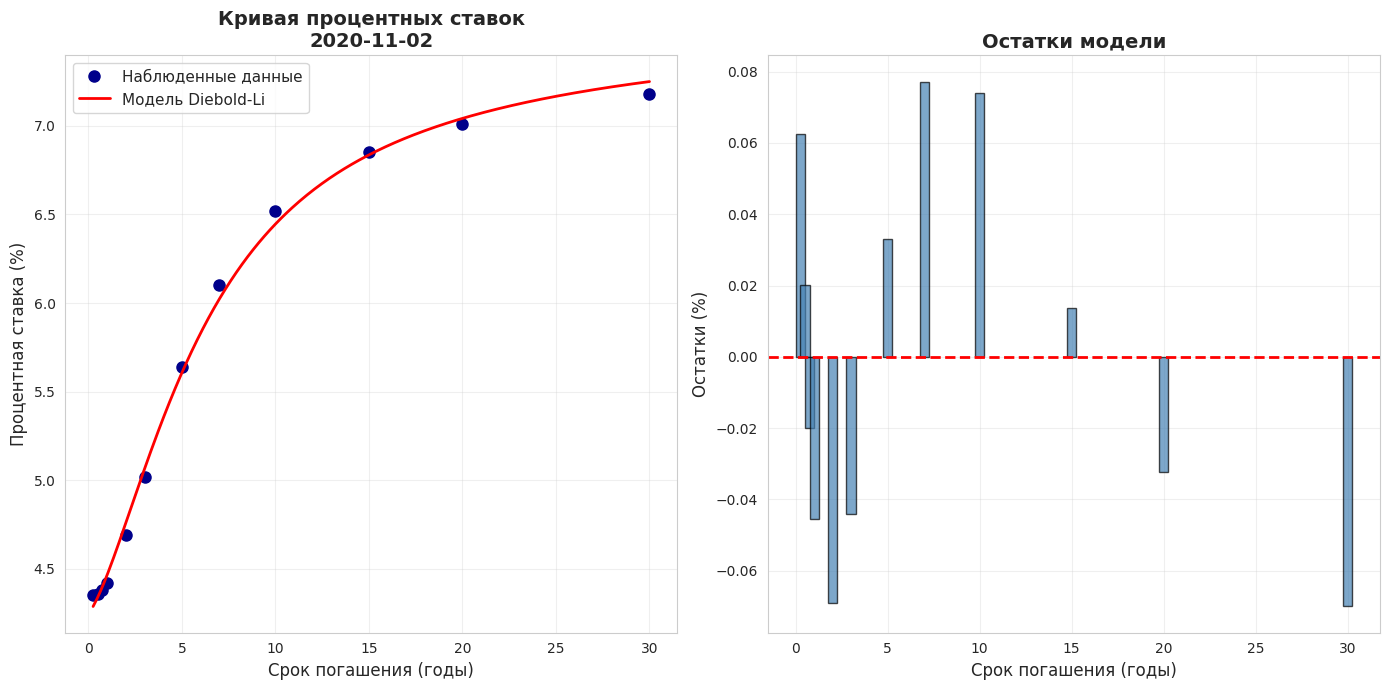

In [5]:
tau_fine = np.linspace(maturities.min(), maturities.max(), 300)
predicted_fine = model.predict(tau_fine)
predicted_original = model.predict(maturities)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(maturities, yields_sample, 'o', markersize=8, label='Наблюденные данные', color='darkblue')
plt.plot(tau_fine, predicted_fine, '-', linewidth=2, label='Модель Diebold-Li', color='red')
plt.xlabel('Срок погашения (годы)', fontsize=12)
plt.ylabel('Процентная ставка (%)', fontsize=12)
plt.title(f'Кривая процентных ставок\n{sample_date.date()}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

residuals = yields_sample - predicted_original
plt.subplot(1, 2, 2)
plt.bar(maturities, residuals, width=0.5, alpha=0.7, color='steelblue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Срок погашения (годы)', fontsize=12)
plt.ylabel('Остатки (%)', fontsize=12)
plt.title('Остатки модели', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Обучение на всех датах


In [6]:
from tqdm.auto import tqdm

results = {
    'date': [],
    'beta0': [],
    'beta1': [],
    'beta2': [],
    'rmse': [],
    'r2': [],
    'mae': []
}

for date_idx in tqdm(range(len(df)), desc="Обучение Diebold-Li"):
    date = df.index[date_idx]
    yields = df.iloc[date_idx].values
    
    model_temp = DieboldLiModel(tau=2.0)
    model_temp.fit(maturities, yields)
    
    results['date'].append(date)
    results['beta0'].append(model_temp.params[0])
    results['beta1'].append(model_temp.params[1])
    results['beta2'].append(model_temp.params[2])
    
    metrics = model_temp.score(maturities, yields)
    results['rmse'].append(metrics['RMSE'])
    results['r2'].append(metrics['R²'])
    results['mae'].append(metrics['MAE'])

results_df = pd.DataFrame(results)
results_df.set_index('date', inplace=True)


Обучение Diebold-Li:   0%|          | 0/1256 [00:00<?, ?it/s]

In [7]:
results_df[['beta0', 'beta1', 'beta2']].describe()


,beta0,beta1,beta2
count,1256.000000,1256.000000,1256.000000
mean,11.548002,-0.098698,-1.006942
std,2.696835,3.645573,3.895115
min,7.161032,-5.799821,-12.799684
25%,8.884740,-3.154655,-3.203447
50%,12.100453,-0.073437,-1.337900
75%,13.885754,1.557027,1.136637
max,16.292943,11.205763,11.022091


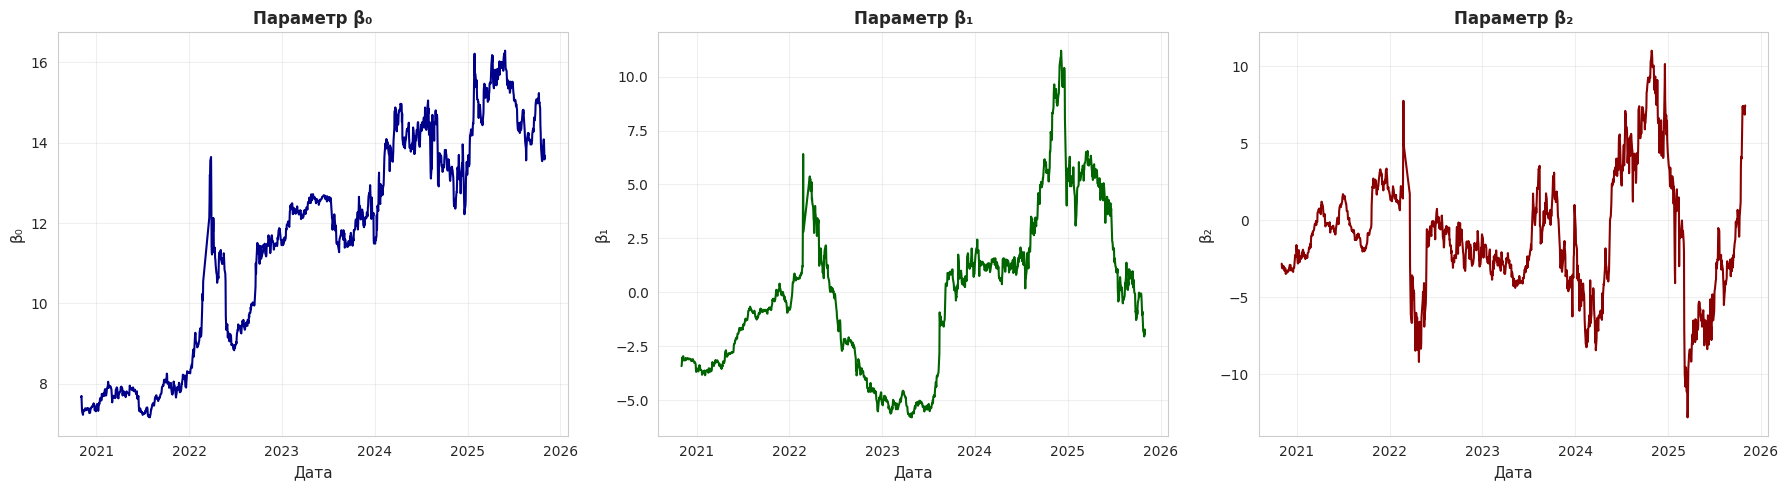

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results_df.index, results_df['beta0'], linewidth=1.5, color='darkblue')
axes[0].set_title('Параметр β₀', fontsize=12, fontweight='bold')
axes[0].set_ylabel('β₀', fontsize=11)
axes[0].set_xlabel('Дата', fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df.index, results_df['beta1'], linewidth=1.5, color='darkgreen')
axes[1].set_title('Параметр β₁', fontsize=12, fontweight='bold')
axes[1].set_ylabel('β₁', fontsize=11)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_df.index, results_df['beta2'], linewidth=1.5, color='darkred')
axes[2].set_title('Параметр β₂', fontsize=12, fontweight='bold')
axes[2].set_ylabel('β₂', fontsize=11)
axes[2].set_xlabel('Дата', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


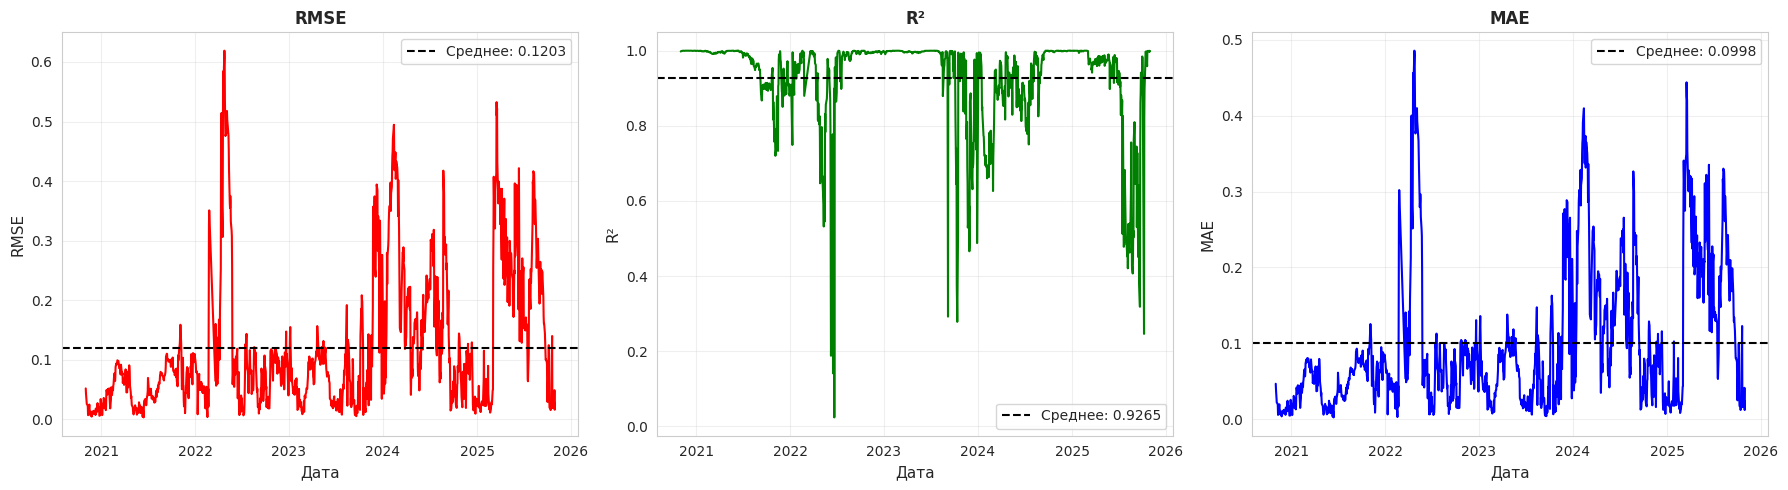

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results_df.index, results_df['rmse'], linewidth=1.5, color='red')
axes[0].set_title('RMSE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=11)
axes[0].set_xlabel('Дата', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=results_df['rmse'].mean(), color='black', linestyle='--', 
                label=f'Среднее: {results_df["rmse"].mean():.4f}')
axes[0].legend()

axes[1].plot(results_df.index, results_df['r2'], linewidth=1.5, color='green')
axes[1].set_title('R²', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R²', fontsize=11)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=results_df['r2'].mean(), color='black', linestyle='--', 
                label=f'Среднее: {results_df["r2"].mean():.4f}')
axes[1].legend()

axes[2].plot(results_df.index, results_df['mae'], linewidth=1.5, color='blue')
axes[2].set_title('MAE', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=11)
axes[2].set_xlabel('Дата', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=results_df['mae'].mean(), color='black', linestyle='--', 
                label=f'Среднее: {results_df["mae"].mean():.4f}')
axes[2].legend()

plt.tight_layout()
plt.show()


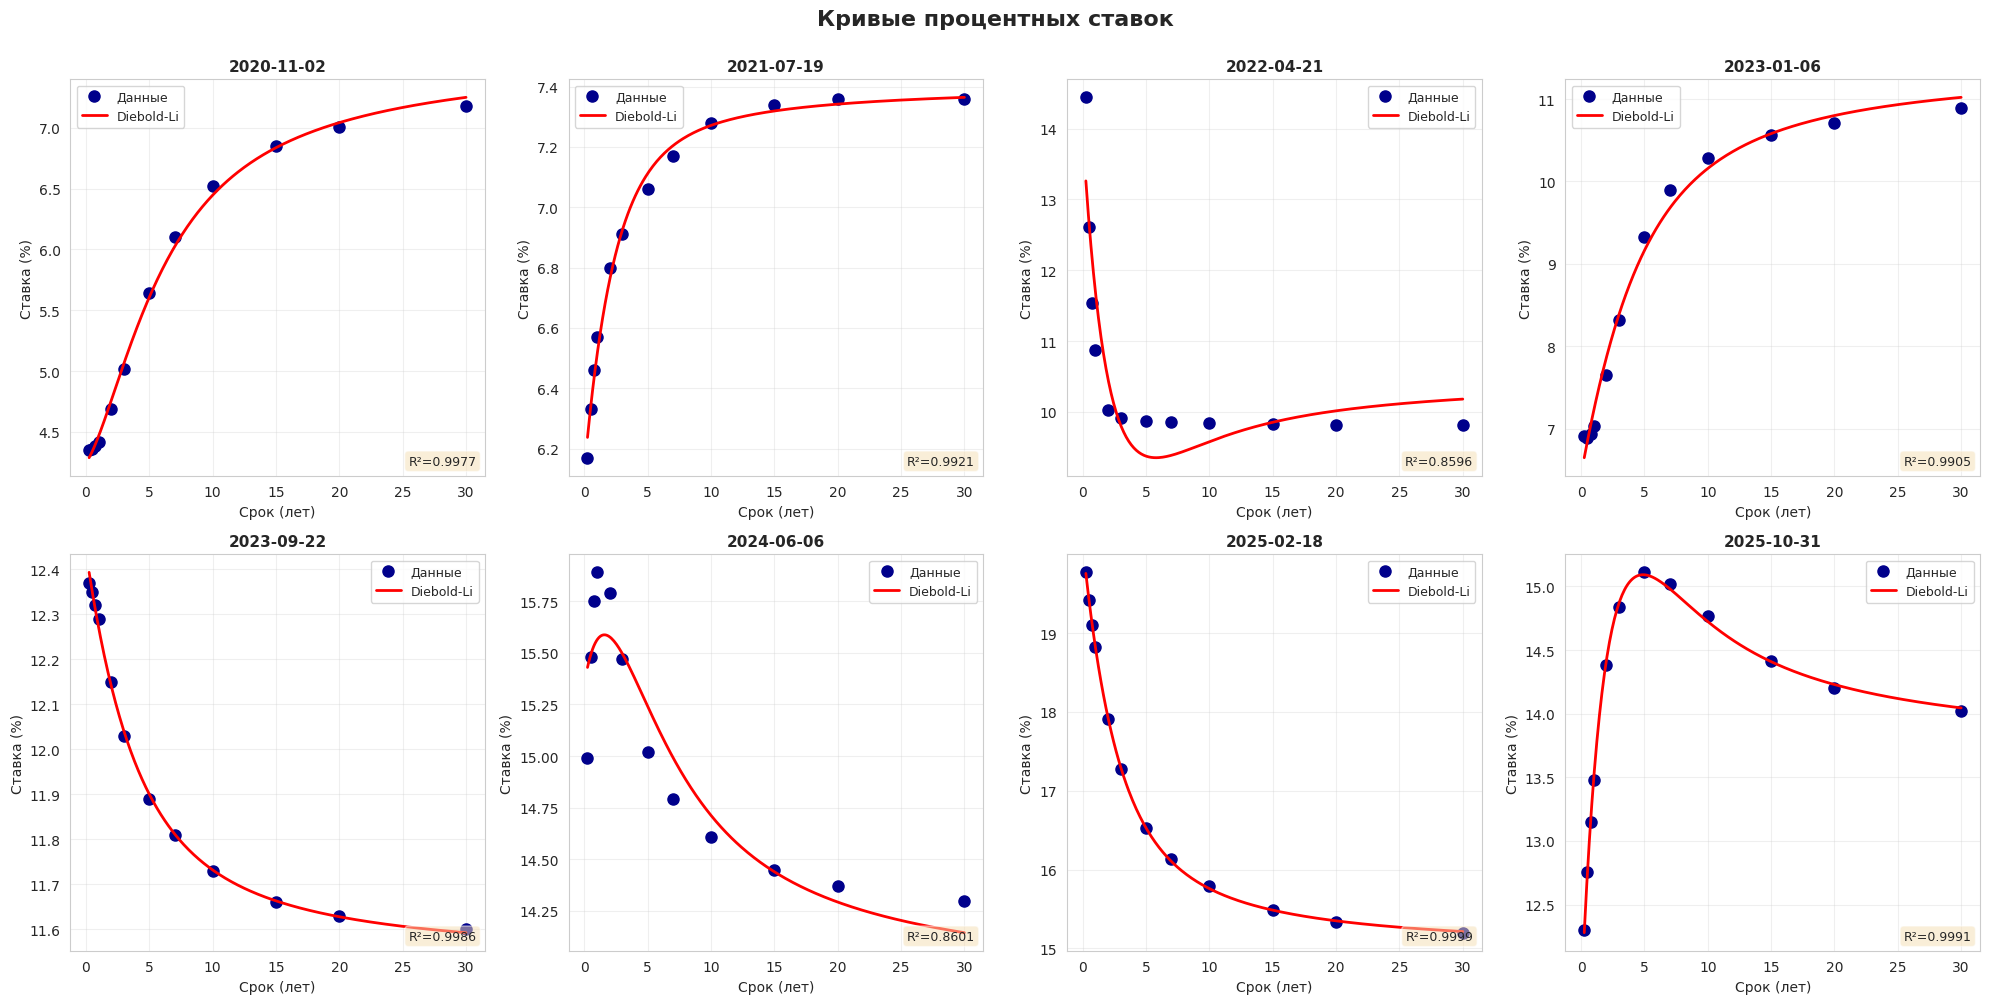

In [10]:
n_samples = 8
indices = np.linspace(0, len(df)-1, n_samples, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

tau_fine = np.linspace(maturities.min(), maturities.max(), 300)

for i, idx in enumerate(indices):
    date = df.index[idx]
    yields = df.iloc[idx].values
    
    model_viz = DieboldLiModel(tau=2.0)
    model_viz.fit(maturities, yields)
    predicted_fine = model_viz.predict(tau_fine)
    
    axes[i].plot(maturities, yields, 'o', markersize=8, label='Данные', color='darkblue')
    axes[i].plot(tau_fine, predicted_fine, '-', linewidth=2, label='Diebold-Li', color='red')
    axes[i].set_title(f'{date.date()}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Срок (лет)', fontsize=10)
    axes[i].set_ylabel('Ставка (%)', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    metrics = model_viz.score(maturities, yields)
    axes[i].text(0.98, 0.02, f'R²={metrics["R²"]:.4f}', 
                transform=axes[i].transAxes, fontsize=9,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Кривые процентных ставок', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [11]:
results_df.to_csv('../results/diebold_li_results.csv')

summary = {
    'Метрика': ['RMSE (среднее)', 'RMSE (мин)', 'RMSE (макс)', 
                'R² (среднее)', 'R² (мин)', 'R² (макс)',
                'MAE (среднее)', 'MAE (мин)', 'MAE (макс)'],
    'Значение': [
        results_df['rmse'].mean(),
        results_df['rmse'].min(),
        results_df['rmse'].max(),
        results_df['r2'].mean(),
        results_df['r2'].min(),
        results_df['r2'].max(),
        results_df['mae'].mean(),
        results_df['mae'].min(),
        results_df['mae'].max()
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('../results/diebold_li_summary.csv', index=False)
